# High Cardinality Features
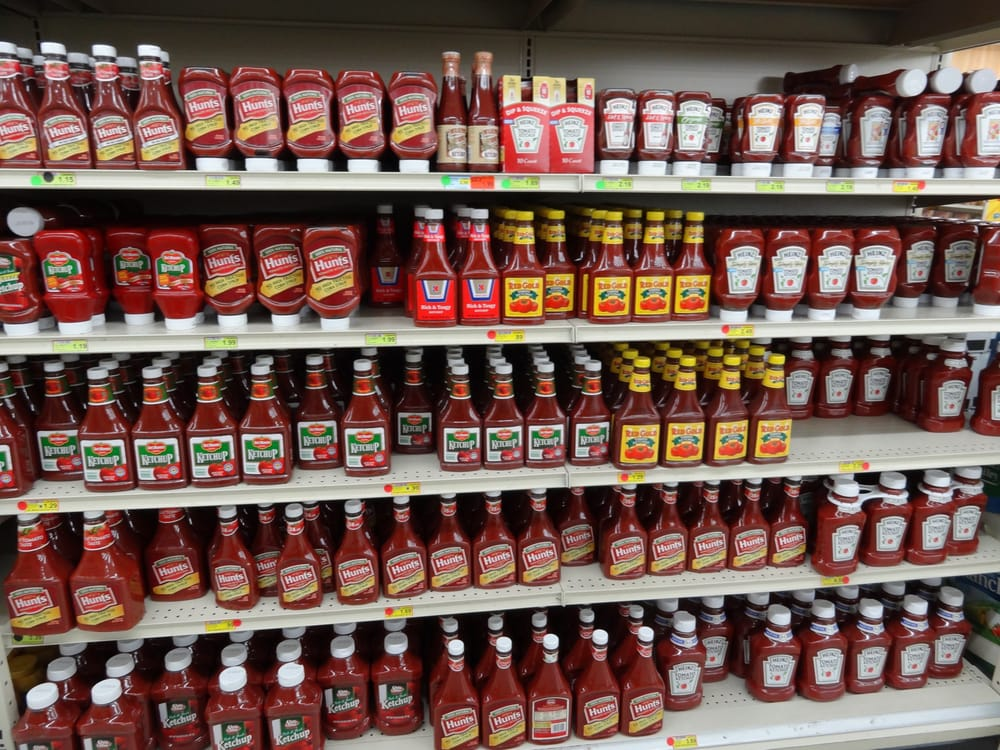

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import pandas_profiling
import vtreat
import category_encoders as ce

from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import feature_engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from feature_engine.categorical_encoders import MeanCategoricalEncoder
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder

# Data
* Allstate Kaggle Competition Data
* 40k rows with 9 high cardinality variables, 9 numerical and regression loss
* https://www.kaggle.com/c/allstate-claims-severity/data

In [2]:
df = pd.read_csv('./allstate.csv')

In [3]:
df = df[['cat108', 'cat109', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat15', 'cat116', 
         'cont1',  'cont2',  'cont3',  'cont4',  'cont5',  'cont6',  'cont7',  'cont8', 'cont9',
         'loss']]

In [4]:
df = df[0:40000]

In [5]:
df.head()

cat108 cat109 cat110 cat111 cat112 cat113 cat114 cat15 cat116     cont1  \
0      G     BU     BC      C     AS      S      A     A     LB  0.726300   
1      K     BI     CQ      A     AV     BM      A     A     DP  0.330514   
2      A     AB     DK      A      C     AF      A     A     GK  0.261841   
3      K     BI     CS      C      N     AE      A     A     DJ  0.321594   
4      B      H      C      C      Y     BM      A     A     CK  0.273204   

      cont2     cont3     cont4     cont5     cont6     cont7    cont8  \
0  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060  0.30260   
1  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585  0.60087   
2  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545  0.27320   
3  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128  0.31796   
4  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408  0.24564   

     cont9     loss  
0  0.67135  2213.18  
1  0.35127  1283.60  
2  0.26076  3005.09  
3  0.32128   939.85  
4  0.22089  2763.85

In [6]:
df.shape

(40000, 19)

# EDA

In [7]:
%%time
pandas_profiling.ProfileReport(df)

CPU times: user 44.7 s, sys: 2.99 s, total: 47.6 s
Wall time: 42.5 s


# Pipeline

In [8]:
## Test / Train 
catColumns = ['cat108', 'cat109', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat15', 'cat116']
numColumns = ['cont1',  'cont2',  'cont3',  'cont4',  'cont5',  'cont6',  'cont7',  'cont8', 'cont9']
X = df.drop('loss', axis=1)
y = df['loss']

# Seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=251)

# Drop rows where we have an unseen level (for convenience)
# Normally, you would want to capture these into an "unknown / unseen" category
for col in catColumns:
    y_test = y_test[X_test[col].isin(X_train[col])]
    X_test = X_test[X_test[col].isin(X_train[col])]

In [9]:
def evaluate(truth, pred):
    mae  = mean_absolute_error(truth, pred)
    mse  = mean_squared_error(truth, pred)
    rmse = math.sqrt(mse)
    return (mae, mse, rmse)
resultsDF = pd.DataFrame(columns=['Estimator', 'Encoding', 'MAE', 'MSE', 'RMSE'])
shapeDF   = pd.DataFrame(columns=['Original', 'Final'])

# Numeric Encoding

## Feature Engine Module
* https://github.com/solegalli/feature_engine
* Module focused on categorical encoding
* Paradigm is DataFrame -> DataFrame rather than DataFrame -> np.array
* In addition to encoding contains approaches for:
 * Missing data imputation
 * Outlier removal
 * Discretisation
 * Numerical Transformation

## One Hot Encoding
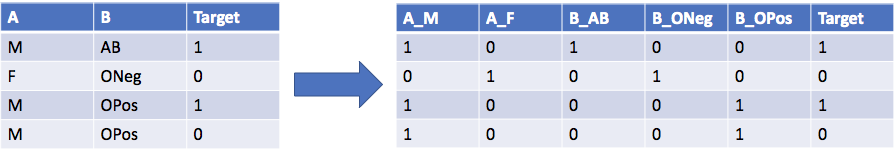

In [10]:
ohe  = OneHotCategoricalEncoder(variables = catColumns, drop_last=True)
sample = Pipeline(steps=[('ohe', ohe)]).fit_transform(X_train, y_train)
shapeDF.loc['One Hot'] = [X.shape[1], sample.shape[1]]
sample.head()

cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
26435  0.330514  0.737068  0.613660  0.473202  0.908217  0.240069  0.283691   
4040   0.338258  0.737068  0.506105  0.327354  0.951977  0.364464  0.337594   
19863  0.378225  0.681761  0.673861  0.244390  0.610834  0.448496  0.713440   
19674  0.523592  0.245921  0.162313  0.201989  0.281143  0.880500  0.972557   
4071   0.113337  0.245921  0.162313  0.259793  0.508483  0.332441  0.304901   

         cont8    cont9  cat108_B    ...      cat116_JE  cat116_BA  cat116_CH  \
26435  0.24564  0.30859         1    ...              0          0          0   
4040   0.49462  0.29269         1    ...              0          0          0   
19863  0.45289  0.43111         0    ...              0          0          0   
19674  0.27320  0.50420         0    ...              0          0          0   
4071   0.29758  0.17321         0    ...              0          0          0   

       cat116_KE  cat116_CE  cat116_LK  cat116_FL  cat116_JA  cat116_JC  \
26435          0          0          0          0          0          0   
4040           0          0          0          0          0          0   
19863          0          0          0          0          0          0   
19674          0          0          0          0          0          0   
4071           0          0          0          0          0          0   

       cat116_FF  
26435          0  
4040           0  
19863          0  
19674          0  
4071           0  

[5 rows x 548 columns]

### Linear Regression
* Unstable - Notice the huge MAE & RMSE
* Ignoring this technique

In [11]:
%%time
est  = LinearRegression()
ohe  = OneHotCategoricalEncoder(variables = catColumns, drop_last=True)
pipe = Pipeline(steps=[('ohe', ohe), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
#Skip Recording due to instability
#resultsDF.loc['Linear:One Hot'] = ['Linear', 'One Hot', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   1.4s
[Pipeline] ............... (step 2 of 2) Processing est, total=   0.6s
MAE  1,906,057,643,914.30
RMSE 134,549,309,648,816.11
CPU times: user 4.04 s, sys: 901 ms, total: 4.94 s
Wall time: 3.53 s


### Random Forest

In [12]:
est  = RandomForestRegressor(n_estimators=100)
ohe  = OneHotCategoricalEncoder(variables = catColumns, drop_last=False)
pipe = Pipeline(steps=[('ohe', ohe), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:One Hot'] = ['Random Forest', 'One Hot', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   1.5s
[Pipeline] ............... (step 2 of 2) Processing est, total= 1.2min
MAE  1,904.60
RMSE 2,851.62


## Rare Level Encoding

In [13]:
rare  = RareLabelCategoricalEncoder(variables = catColumns)
sample = Pipeline(steps=[('rare', rare)]).fit_transform(X, y)
sample.head()

cat108 cat109 cat110 cat111 cat112 cat113 cat114 cat15 cat116     cont1  \
0      G   Rare   Rare      C     AS   Rare      A     A   Rare  0.726300   
1      K     BI   Rare      A   Rare     BM      A     A   Rare  0.330514   
2   Rare     AB   Rare      A   Rare   Rare      A     A   Rare  0.261841   
3      K     BI     CS      C   Rare     AE      A     A     DJ  0.321594   
4      B   Rare   Rare      C   Rare     BM      A     A     CK  0.273204   

      cont2     cont3     cont4     cont5     cont6     cont7    cont8  \
0  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060  0.30260   
1  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585  0.60087   
2  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545  0.27320   
3  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128  0.31796   
4  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408  0.24564   

     cont9  
0  0.67135  
1  0.35127  
2  0.26076  
3  0.32128  
4  0.22089

In [14]:
rare  = RareLabelCategoricalEncoder(variables = catColumns)
ohe   = OneHotCategoricalEncoder(variables = catColumns)
sample = Pipeline(steps=[('rare', rare), ('ohe', ohe)]).fit_transform(X, y)
shapeDF.loc['Rare'] = [X.shape[1], sample.shape[1]]
sample.head()

cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.726300  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060   
1  0.330514  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585   
2  0.261841  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545   
3  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128   
4  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408   

     cont8    cont9  cat108_G    ...      cat114_A  cat114_Rare  cat114_E  \
0  0.30260  0.67135         1    ...             1            0         0   
1  0.60087  0.35127         0    ...             1            0         0   
2  0.27320  0.26076         0    ...             1            0         0   
3  0.31796  0.32128         0    ...             1            0         0   
4  0.24564  0.22089         0    ...             1            0         0   

   cat114_C  cat15_A  cat15_B  cat116_Rare  cat116_DJ  cat116_CK  cat116_HK  
0         0        1        0            1          0          0          0  
1         0        1        0            1          0          0          0  
2         0        1        0            1          0          0          0  
3         0        1        0            0          1          0          0  
4         0        1        0            0          0          1          0  

[5 rows x 50 columns]

### Linear Regression
* Caution there can be singularities with this sparse data on Linear Regression

In [15]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('rare', rare), ('ohe', ohe), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:Rare'] = ['Linear', 'Rare', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] .............. (step 1 of 3) Processing rare, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing ohe, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing est, total=   0.0s
MAE  1,863.90
RMSE 2,713.71
CPU times: user 506 ms, sys: 76.7 ms, total: 583 ms
Wall time: 278 ms


### Random Forest

In [16]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('rare', rare), ('ohe', ohe), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Rare'] = ['Random Forest', 'Rare', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] .............. (step 1 of 3) Processing rare, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing ohe, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing est, total=  14.7s
MAE  1,987.71
RMSE 2,925.09
CPU times: user 15.4 s, sys: 168 ms, total: 15.6 s
Wall time: 15.4 s


## Label / Ordinal Encoding
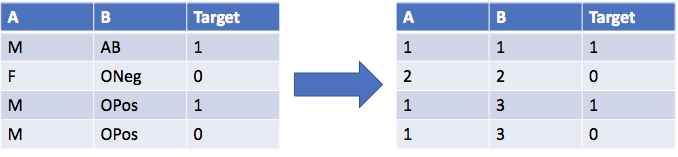

In [17]:
ord  = OrdinalCategoricalEncoder(variables = catColumns)
sample = Pipeline(steps=[('ord', ord)]).fit_transform(X, y)
shapeDF.loc['Ordinal'] = [X.shape[1], sample.shape[1]]
sample.head()

cat108  cat109  cat110  cat111  cat112  cat113  cat114  cat15  cat116  \
0       6      56      70       1      48      14       6      1     123   
1       3      64      77       0       1      19       6      1     134   
2       5      54      79       0      40      23       6      1     101   
3       3      64      89       1      31      17       6      1     125   
4       2      41      55       1       6      19       6      1     135   

      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.726300  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060   
1  0.330514  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585   
2  0.261841  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545   
3  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128   
4  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408   

     cont8    cont9  
0  0.30260  0.67135  
1  0.60087  0.35127  
2  0.27320  0.26076  
3  0.31796  0.32128  
4  0.24564  0.22089

### Linear Regression

In [18]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('ord', ord), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:Ordinal'] = ['Linear', 'Ordinal', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 2) Processing ord, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing est, total=   0.0s
MAE  1,842.53
RMSE 2,689.60
CPU times: user 162 ms, sys: 19.1 ms, total: 181 ms
Wall time: 87.5 ms


### Random Forest

In [19]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('ord', ord), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Ordinal'] = ['Random Forest', 'Ordinal', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 2) Processing ord, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing est, total=  13.3s
MAE  1,955.21
RMSE 2,863.86
CPU times: user 13.9 s, sys: 156 ms, total: 14 s
Wall time: 13.8 s


## Mean Encoding
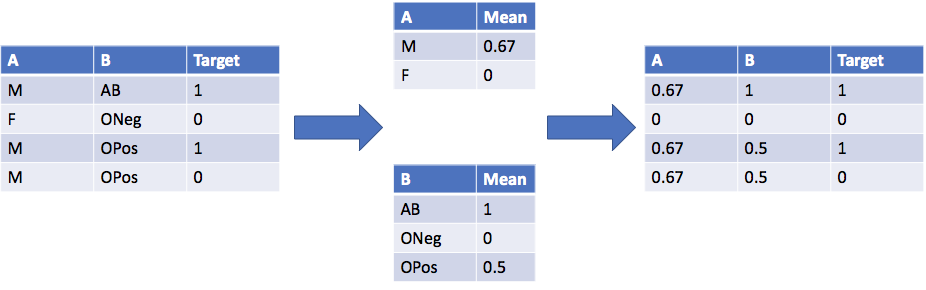

In [20]:
meanE  = MeanCategoricalEncoder(variables = catColumns)
sample = Pipeline(steps=[('meanE', meanE)]).fit_transform(X, y)
shapeDF.loc['Mean'] = [X.shape[1], sample.shape[1]]
sample.head()

cat108       cat109       cat110       cat111       cat112  \
0  3138.129744  2709.672378  2728.599900  3117.531165  3421.854336   
1  2894.046304  3143.870289  2877.132920  2817.138335  2302.991688   
2  2952.856194  2591.006991  2906.057143  2817.138335  3190.104892   
3  2894.046304  3143.870289  3020.412230  3117.531165  3085.359082   
4  2835.162719  2238.070769  2382.333957  3117.531165  2503.455867   

        cat113       cat114        cat15       cat116     cont1     cont2  \
0  2792.624256  3254.049606  3032.820637  2898.301581  0.726300  0.245921   
1  2894.344221  3254.049606  3032.820637  3052.685373  0.330514  0.737068   
2  2991.276667  3254.049606  3032.820637  2686.175949  0.261841  0.358319   
3  2863.193010  3254.049606  3032.820637  2905.693050  0.321594  0.555782   
4  2894.344221  3254.049606  3032.820637  3063.360584  0.273204  0.159990   

      cont3     cont4     cont5     cont6     cont7    cont8    cont9  
0  0.187583  0.789639  0.310061  0.718367  0.335060  0.30260  0.67135  
1  0.592681  0.614134  0.885834  0.438917  0.436585  0.60087  0.35127  
2  0.484196  0.236924  0.397069  0.289648  0.315545  0.27320  0.26076  
3  0.527991  0.373816  0.422268  0.440945  0.391128  0.31796  0.32128  
4  0.527991  0.473202  0.704268  0.178193  0.247408  0.24564  0.22089

### Linear Regression

In [21]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('meanE', meanE), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:Mean'] = ['Linear', 'Mean', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............. (step 1 of 2) Processing meanE, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing est, total=   0.0s
MAE  1,839.77
RMSE 2,713.64
CPU times: user 171 ms, sys: 26.3 ms, total: 197 ms
Wall time: 91.9 ms


### Random Forest

In [22]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('meanE', meanE), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Mean'] = ['Random Forest', 'Mean', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............. (step 1 of 2) Processing meanE, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing est, total=  13.6s
MAE  1,957.36
RMSE 2,866.88
CPU times: user 14.1 s, sys: 160 ms, total: 14.3 s
Wall time: 14.1 s


## Count Frequency
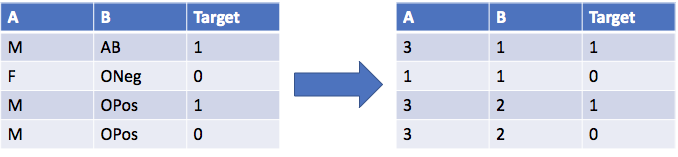

In [23]:
freq  = CountFrequencyCategoricalEncoder(variables = catColumns)
sample = Pipeline(steps=[('freq', freq)]).fit_transform(X, y)
shapeDF.loc['Count'] = [X.shape[1], sample.shape[1]]
sample.head()

cat108  cat109  cat110  cat111  cat112  cat113  cat114  cat15  cat116  \
0    4529     656     896    6887    3817    1485   27764  39997     658   
1    9113   32427     661   27335    1499    5517   27764  39997    1906   
2    1897    4623     357   27335     464    1287   27764  39997     548   
3    9113   32427    5259    6887    1808    4780   27764  39997    4302   
4   13951      13     556    6887     300    5517   27764  39997    2140   

      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.726300  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060   
1  0.330514  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585   
2  0.261841  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545   
3  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128   
4  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408   

     cont8    cont9  
0  0.30260  0.67135  
1  0.60087  0.35127  
2  0.27320  0.26076  
3  0.31796  0.32128  
4  0.24564  0.22089

### Linear Regression

In [24]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('freq', freq), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:Freq'] = ['Linear', 'Freq', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] .............. (step 1 of 2) Processing freq, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing est, total=   0.0s
MAE  1,904.55
RMSE 2,749.09
CPU times: user 207 ms, sys: 33.6 ms, total: 240 ms
Wall time: 111 ms


### Random Forest

In [25]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('freq', freq), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Freq'] = ['Random Forest', 'Freq', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] .............. (step 1 of 2) Processing freq, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing est, total=  13.0s
MAE  1,968.26
RMSE 2,882.35
CPU times: user 13.6 s, sys: 160 ms, total: 13.8 s
Wall time: 13.6 s


## Combinations

In [26]:
X_train_num = X_train[numColumns]
X_train_cat = X_train[catColumns]
X_test_num  = X_test[numColumns]
X_test_cat  = X_test[catColumns]

ohe = OneHotCategoricalEncoder(variables=catColumns, drop_last=True)
X_train_ohe = ohe.fit_transform(X_train_cat, y_train).add_prefix('ohe_')
X_test_ohe  = ohe.transform(X_test_cat).add_prefix('ohe_')

rare = RareLabelCategoricalEncoder(variables=catColumns)
ohe  = OneHotCategoricalEncoder(variables=catColumns)
rarePipeline = Pipeline(steps=[('rare', rare), ('ohe', ohe)])
X_train_rare = rarePipeline.fit_transform(X_train_cat, y_train).add_prefix('rare_')
X_test_rare  = rarePipeline.transform(X_test_cat).add_prefix('rare_')

ordinal = OrdinalCategoricalEncoder(variables=catColumns)
X_train_ordinal = ordinal.fit_transform(X_train_cat, y_train).add_prefix('ordinal_')
X_test_ordinal  = ordinal.transform(X_test_cat).add_prefix('ordinal_')

meanE = MeanCategoricalEncoder(variables=catColumns)
X_train_mean = meanE.fit_transform(X_train_cat, y_train).add_prefix('mean_')
X_test_mean  = meanE.transform(X_test_cat).add_prefix('mean_')

freq = CountFrequencyCategoricalEncoder(variables=catColumns)
X_train_freq = freq.fit_transform(X_train_cat, y_train).add_prefix('freq_')
X_test_freq  = freq.transform(X_test_cat).add_prefix('freq_')

X_train_combo = pd.concat([X_train_num, 
                           X_train_ohe, 
                           X_train_rare,
                           X_train_ordinal,
                           X_train_mean,
                           X_train_freq], axis=1)
X_test_combo = pd.concat([X_test_num, 
                           X_test_ohe, 
                           X_test_rare,
                           X_test_ordinal,
                           X_test_mean,
                           X_test_freq], axis=1)

In [27]:
shapeDF.loc['Combination'] = [X.shape[1], X_train_combo.shape[1]]
X_train_combo.head()

cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
26435  0.330514  0.737068  0.613660  0.473202  0.908217  0.240069  0.283691   
4040   0.338258  0.737068  0.506105  0.327354  0.951977  0.364464  0.337594   
19863  0.378225  0.681761  0.673861  0.244390  0.610834  0.448496  0.713440   
19674  0.523592  0.245921  0.162313  0.201989  0.281143  0.880500  0.972557   
4071   0.113337  0.245921  0.162313  0.259793  0.508483  0.332441  0.304901   

         cont8    cont9  ohe_cat108_B     ...       mean_cat116  freq_cat108  \
26435  0.24564  0.30859             1     ...       3049.865056         6944   
4040   0.49462  0.29269             1     ...       3386.741622         6944   
19863  0.45289  0.43111             0     ...       4800.798868         1979   
19674  0.27320  0.50420             0     ...       2968.367750          819   
4071   0.29758  0.17321             0     ...       2463.257619         4601   

       freq_cat109  freq_cat110  freq_cat111  freq_cat112  freq_cat113  \
26435        16218         2600         3442          158         2774   
4040         16218         2671          380          904          378   
19863        16218         2671         3442         2715          455   
19674        16218         2671         1516         1005          517   
4071          2327          408        13655          654          502   

       freq_cat114  freq_cat15  freq_cat116  
26435        13814       19999         1076  
4040         13814       19999           74  
19863        13814       19999           53  
19674        13814       19999          320  
4071         13814       19999          105  

[5 rows x 617 columns]

### Linear Regression
* Unstable - Notice the huge MAE & RMSE
* Ignoring this technique

In [28]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('est', est)], verbose = True) 
pipe.fit(X_train_combo, y_train)
y_hat = pipe.predict(X_test_combo)
mae, mse, rmse = evaluate(y_test, y_hat)
# Ignoring due to instability
# resultsDF.loc['Linear:Combo'] = ['Linear', 'Combo', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 1) Processing est, total=   0.9s
MAE  183,934.85
RMSE 12,853,800.46
CPU times: user 2.3 s, sys: 347 ms, total: 2.65 s
Wall time: 1.02 s


### Random Forest

In [29]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('est', est)], verbose = True) 
pipe.fit(X_train_combo, y_train)
y_hat = pipe.predict(X_test_combo)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Combination'] = ['Random Forest', 'Combo', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 1) Processing est, total= 1.4min
MAE  1,930.74
RMSE 2,851.25
CPU times: user 1min 25s, sys: 328 ms, total: 1min 25s
Wall time: 1min 25s


## Comparison

### Linear

In [30]:
resultsDF[resultsDF.Estimator == 'Linear'].sort_values('MAE')

Estimator Encoding          MAE           MSE         RMSE
Linear:Mean       Linear     Mean  1839.768860  7.363863e+06  2713.643843
Linear:Ordinal    Linear  Ordinal  1842.528797  7.233940e+06  2689.598435
Linear:Rare       Linear     Rare  1863.902639  7.364246e+06  2713.714480
Linear:Freq       Linear     Freq  1904.550644  7.557520e+06  2749.094374

### Random Forest

In [31]:
resultsDF[resultsDF.Estimator == 'Random Forest'].sort_values('MAE')

Estimator Encoding          MAE           MSE         RMSE
RF:One Hot      Random Forest  One Hot  1904.597014  8.131723e+06  2851.617562
RF:Combination  Random Forest    Combo  1930.739087  8.129618e+06  2851.248433
RF:Ordinal      Random Forest  Ordinal  1955.213077  8.201696e+06  2863.860252
RF:Mean         Random Forest     Mean  1957.358213  8.219005e+06  2866.880748
RF:Freq         Random Forest     Freq  1968.259393  8.307929e+06  2882.347884
RF:Rare         Random Forest     Rare  1987.709370  8.556163e+06  2925.091972

# Hash Encoding
* Using the contrib package categorical_encoders
* Compress each value in each object column into n_components

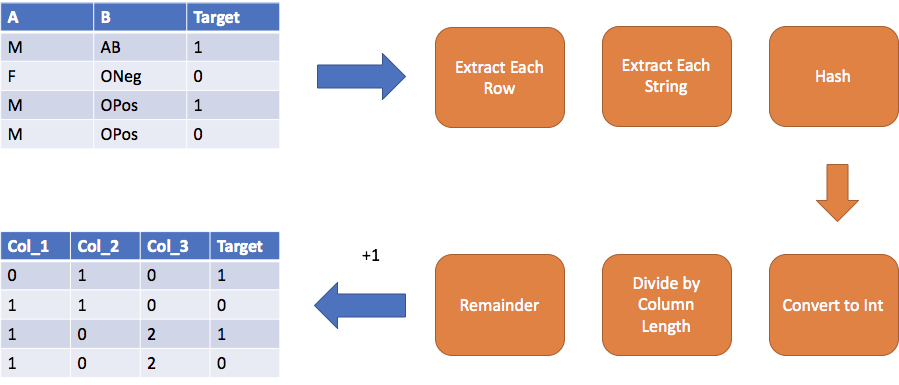

In [32]:
he = ce.HashingEncoder(cols=catColumns, n_components=8)
sample = he.fit_transform(X_train)
sample.head()

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7     cont1  \
26435      0      3      2      1      1      1      0      1  0.330514   
4040       1      3      2      1      0      0      0      2  0.338258   
19863      1      2      2      1      0      1      1      1  0.378225   
19674      1      3      3      0      1      1      0      0  0.523592   
4071       2      4      0      0      0      0      1      2  0.113337   

          cont2     cont3     cont4     cont5     cont6     cont7    cont8  \
26435  0.737068  0.613660  0.473202  0.908217  0.240069  0.283691  0.24564   
4040   0.737068  0.506105  0.327354  0.951977  0.364464  0.337594  0.49462   
19863  0.681761  0.673861  0.244390  0.610834  0.448496  0.713440  0.45289   
19674  0.245921  0.162313  0.201989  0.281143  0.880500  0.972557  0.27320   
4071   0.245921  0.162313  0.259793  0.508483  0.332441  0.304901  0.29758   

         cont9  
26435  0.30859  
4040   0.29269  
19863  0.43111  
19674  0.50420  
4071   0.17321

## Linear Regression

In [33]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('he', he), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:Hash'] = ['Linear', 'Hash', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ................ (step 1 of 2) Processing he, total=  15.8s
[Pipeline] ............... (step 2 of 2) Processing est, total=   0.0s
MAE  1,944.28
RMSE 2,790.23
CPU times: user 23.2 s, sys: 521 ms, total: 23.7 s
Wall time: 23.4 s


## Random Forest

In [34]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('he', he), ('est', est)], verbose = True) 
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:Hash'] = ['RF', 'Hash', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ................ (step 1 of 2) Processing he, total=  15.4s
[Pipeline] ............... (step 2 of 2) Processing est, total=  10.4s
MAE  2,097.77
RMSE 3,053.24
CPU times: user 33.4 s, sys: 613 ms, total: 34 s
Wall time: 33.8 s


## Categorical_Encoders Module
* http://contrib.scikit-learn.org/categorical-encoding/index.html
* Several other treatments beyond those available in feature_engine:
 * Helmert
 * Leave One Out
 * CatBoost

# VTreat
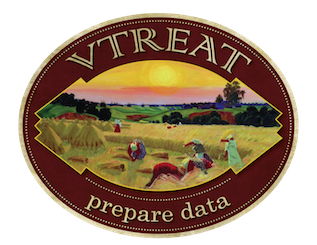

* https://github.com/WinVector/vtreat
* Y-Aware Pre-Processing
* Categorical with many levels
 * Impact Coding
 * OHE Common
* Rare categorical levels
* Novel categorical levels
* Missing data
 * Imputed value
 * Indicator variable
* Extreme Values
 * Reistricted in ranges
* Suppress Constant / Near Constant

In [35]:
plan = vtreat.NumericOutcomeTreatment()
X_train_vtreat = plan.fit_transform(X_train, y_train)
X_test_vtreat  = plan.transform(X_test)

In [36]:
shapeDF.loc['VTreat'] = [X.shape[1], X_train_vtreat.shape[1]]
X_train_vtreat.head()

cont2     cont3     cont4     cont5     cont6     cont7    cont8  \
0  0.737068  0.613660  0.473202  0.908217  0.240069  0.283691  0.24564   
1  0.737068  0.506105  0.327354  0.951977  0.364464  0.337594  0.49462   
2  0.681761  0.673861  0.244390  0.610834  0.448496  0.713440  0.45289   
3  0.245921  0.162313  0.201989  0.281143  0.880500  0.972557  0.27320   
4  0.245921  0.162313  0.259793  0.508483  0.332441  0.304901  0.29758   

     cont9  cat108_impact_code  cat108_deviance_code          ...           \
0  0.30859         -201.495850           2465.809227          ...            
1  0.29269         -207.430741           2502.615436          ...            
2  0.43111          691.272924           4249.837840          ...            
3  0.50420          761.784637           3757.407448          ...            
4  0.17321         -152.735655           2666.663311          ...            

   cat112_deviance_code  cat112_prevalence_code  cat113_impact_code  \
0           2992.294322                 0.00785         -166.329101   
1           3103.696973                 0.04515          219.192130   
2           3140.542531                 0.13570         1364.572297   
3           2834.363880                 0.05020          433.476029   
4           2221.777797                 0.03265         -232.401212   

   cat113_deviance_code  cat113_prevalence_code  cat114_impact_code  \
0           2612.709988                 0.13865          198.850505   
1           2903.299447                 0.01885          206.692051   
2           4257.761562                 0.02270          206.692051   
3           3212.914629                 0.02580          196.547774   
4           2654.213171                 0.02505          206.692051   

   cat114_deviance_code  cat114_prevalence_code  cat116_impact_code  \
0           2874.018286                 0.69065           52.709473   
1           2994.523388                 0.69065          451.373578   
2           2994.523388                 0.69065         2131.426273   
3           2940.284482                 0.69065            6.085349   
4           2994.523388                 0.69065         -575.343529   

   cat116_deviance_code  
0           2612.855863  
1           2893.529261  
2           5932.780030  
3           2869.335315  
4           1582.717208  

[5 rows x 31 columns]

## Linear Regression

In [37]:
%%time
est  = LinearRegression()
pipe = Pipeline(steps=[('est', est)], verbose = True) 
pipe.fit(X_train_vtreat, y_train)
y_hat = pipe.predict(X_test_vtreat)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Linear:VTreat'] = ['Linear', 'VTreat', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 1) Processing est, total=   0.0s
MAE  1,836.86
RMSE 2,688.88
CPU times: user 40.8 ms, sys: 7.53 ms, total: 48.3 ms
Wall time: 19.4 ms


## Random Forest

In [38]:
%%time
est  = RandomForestRegressor(n_estimators=100)
pipe = Pipeline(steps=[('est', est)], verbose = True) 
pipe.fit(X_train_vtreat, y_train)
y_hat = pipe.predict(X_test_vtreat)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['RF:VTreat'] = ['Random Forest', 'VTreat', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

[Pipeline] ............... (step 1 of 1) Processing est, total=  26.2s
MAE  1,858.83
RMSE 2,739.63
CPU times: user 26.8 s, sys: 178 ms, total: 27 s
Wall time: 26.8 s


# CatBoost
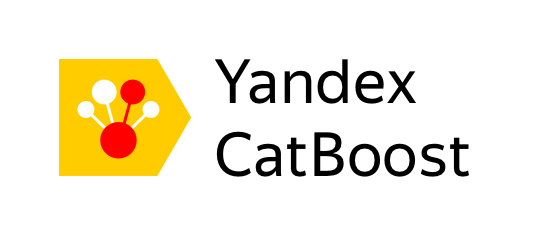

* Gradient Boosting over Decision Trees
* Superior quality when compared with other GBDT libraries on many datasets.
* Best in class prediction speed.
* Support for both numerical and categorical features.
 * Support for categoricals as first class
 * No need to encode
* Fast GPU and multi-GPU support for training out of the box.
* Visualization tools included.

## CatBoost No Treatment

### Setup Data

In [39]:
cat_idx = X_train.columns.get_indexer(X_train.select_dtypes('object').columns)
X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(X_train, y_train, test_size=0.1)

train_pool = Pool(X_cb_train, y_cb_train, cat_features=cat_idx)
val_pool   = Pool(X_cb_val, y_cb_val, cat_features=cat_idx)
test_pool  = Pool(X_test, cat_features=cat_idx) 

shapeDF.loc['CatBoost:None'] = [X.shape[1], X_cb_train.shape[1]]

### Train Model

In [40]:
# specify the training parameters 
model = CatBoostRegressor(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='RMSE')
#train the model
model.fit(train_pool, eval_set=val_pool)

0:	learn: 3972.5716465	test: 4073.8572444	best: 4073.8572444 (0)	total: 83.8ms	remaining: 41.8s
1:	learn: 3785.4435826	test: 3885.3951336	best: 3885.3951336 (1)	total: 113ms	remaining: 28s
2:	learn: 3626.3637281	test: 3724.6872648	best: 3724.6872648 (2)	total: 141ms	remaining: 23.4s
3:	learn: 3487.3592089	test: 3584.9944371	best: 3584.9944371 (3)	total: 170ms	remaining: 21.1s
4:	learn: 3372.9375264	test: 3468.4931704	best: 3468.4931704 (4)	total: 200ms	remaining: 19.8s
5:	learn: 3279.8923762	test: 3371.6567952	best: 3371.6567952 (5)	total: 214ms	remaining: 17.7s
6:	learn: 3196.2274609	test: 3284.8453374	best: 3284.8453374 (6)	total: 249ms	remaining: 17.5s
7:	learn: 3120.1413196	test: 3203.2346938	best: 3203.2346938 (7)	total: 279ms	remaining: 17.2s
8:	learn: 3059.2027994	test: 3140.1309766	best: 3140.1309766 (8)	total: 321ms	remaining: 17.5s
9:	learn: 3009.2169393	test: 3086.4247371	best: 3086.4247371 (9)	total: 367ms	remaining: 18s
10:	learn: 2970.6845977	test: 3046.3676656	best: 3046

### Test Performance

In [41]:
y_hat = model.predict(test_pool)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Catboost:None'] = ['CatBoost', 'None', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

MAE  1,802.71
RMSE 2,682.28


## CatBoost on VTreat

### Setup Data

In [42]:
X_train_treated = X_train_vtreat.to_sparse().to_dense()
X_test_treated  = X_test_vtreat.to_sparse().to_dense()

cat_idx = X_train_treated.columns.get_indexer(X_train_treated.select_dtypes('object').columns)
X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(X_train_treated, y_train, test_size=0.1)

train_pool = Pool(X_cb_train, y_cb_train, cat_features=cat_idx)
val_pool   = Pool(X_cb_val, y_cb_val, cat_features=cat_idx)
test_pool  = Pool(X_test_treated, cat_features=cat_idx) 

shapeDF.loc['CatBoost:VTreat'] = [X.shape[1], X_train_treated.shape[1]]

### Train Model

In [43]:
# specify the training parameters 
model = CatBoostRegressor(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='RMSE')
#train the model
model.fit(train_pool, eval_set=val_pool)

0:	learn: 3950.7687047	test: 4282.1516652	best: 4282.1516652 (0)	total: 20.6ms	remaining: 10.3s
1:	learn: 3760.9633840	test: 4098.3877784	best: 4098.3877784 (1)	total: 32.3ms	remaining: 8.05s
2:	learn: 3597.4832537	test: 3938.9372981	best: 3938.9372981 (2)	total: 43.8ms	remaining: 7.26s
3:	learn: 3459.7265551	test: 3806.4754924	best: 3806.4754924 (3)	total: 55.9ms	remaining: 6.93s
4:	learn: 3344.2909409	test: 3694.3476252	best: 3694.3476252 (4)	total: 67.5ms	remaining: 6.68s
5:	learn: 3245.9917579	test: 3598.8174302	best: 3598.8174302 (5)	total: 79.3ms	remaining: 6.53s
6:	learn: 3161.6572407	test: 3516.7641783	best: 3516.7641783 (6)	total: 90.9ms	remaining: 6.4s
7:	learn: 3093.1060076	test: 3447.9190738	best: 3447.9190738 (7)	total: 102ms	remaining: 6.3s
8:	learn: 3032.1100432	test: 3387.3360833	best: 3387.3360833 (8)	total: 117ms	remaining: 6.37s
9:	learn: 2982.4245738	test: 3338.1002243	best: 3338.1002243 (9)	total: 132ms	remaining: 6.44s
10:	learn: 2939.9525762	test: 3295.3103387	be

### Test Performance

In [44]:
y_hat = model.predict(test_pool)
mae, mse, rmse = evaluate(y_test, y_hat)
resultsDF.loc['Catboost:VTreat'] = ['CatBoost', 'VTreat', mae, mse, rmse]
print('MAE  {:,.2f}'.format(mae))
print('RMSE {:,.2f}'.format(rmse))

MAE  1,809.29
RMSE 2,677.59


# Results

## Column Expansion

In [45]:
shapeDF

Original Final
One Hot               18   548
Rare                  18    50
Ordinal               18    18
Mean                  18    18
Count                 18    18
Combination           18   617
VTreat                18    31
CatBoost:None         18    18
CatBoost:VTreat       18    31

Text(0.5, 1.0, 'Columns After Transformation')

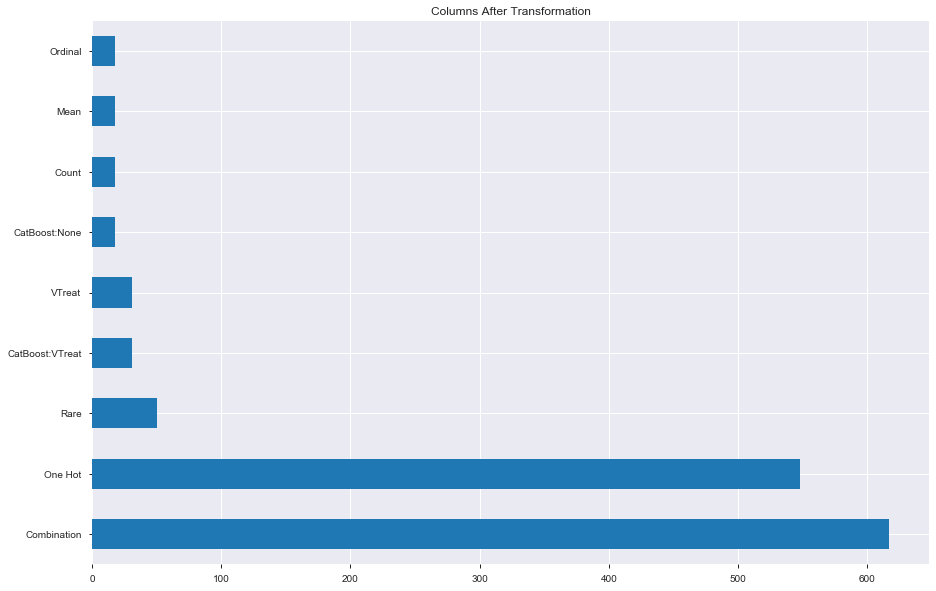

In [46]:
plt.figure(figsize=(15,10))
shapeDF['Final'].sort_values(ascending=False).plot.barh(color='#1f77b4')
plt.title('Columns After Transformation')

## Best MAE

In [47]:
resultsDF.sort_values('MAE')

Estimator Encoding          MAE           MSE  \
Catboost:None         CatBoost     None  1802.712855  7.194605e+06   
Catboost:VTreat       CatBoost   VTreat  1809.292343  7.169504e+06   
Linear:VTreat           Linear   VTreat  1836.856413  7.230088e+06   
Linear:Mean             Linear     Mean  1839.768860  7.363863e+06   
Linear:Ordinal          Linear  Ordinal  1842.528797  7.233940e+06   
RF:VTreat        Random Forest   VTreat  1858.831908  7.505598e+06   
Linear:Rare             Linear     Rare  1863.902639  7.364246e+06   
Linear:Freq             Linear     Freq  1904.550644  7.557520e+06   
RF:One Hot       Random Forest  One Hot  1904.597014  8.131723e+06   
RF:Combination   Random Forest    Combo  1930.739087  8.129618e+06   
Linear:Hash             Linear     Hash  1944.281958  7.785372e+06   
RF:Ordinal       Random Forest  Ordinal  1955.213077  8.201696e+06   
RF:Mean          Random Forest     Mean  1957.358213  8.219005e+06   
RF:Freq          Random Forest     Freq  1968.259393  8.307929e+06   
RF:Rare          Random Forest     Rare  1987.709370  8.556163e+06   
RF:Hash                     RF     Hash  2097.773166  9.322263e+06   

                        RMSE  
Catboost:None    2682.276163  
Catboost:VTreat  2677.592901  
Linear:VTreat    2688.882385  
Linear:Mean      2713.643843  
Linear:Ordinal   2689.598435  
RF:VTreat        2739.634673  
Linear:Rare      2713.714480  
Linear:Freq      2749.094374  
RF:One Hot       2851.617562  
RF:Combination   2851.248433  
Linear:Hash      2790.228017  
RF:Ordinal       2863.860252  
RF:Mean          2866.880748  
RF:Freq          2882.347884  
RF:Rare          2925.091972  
RF:Hash          3053.238069

Text(0.5, 1.0, 'MAE by Model & Treatment')

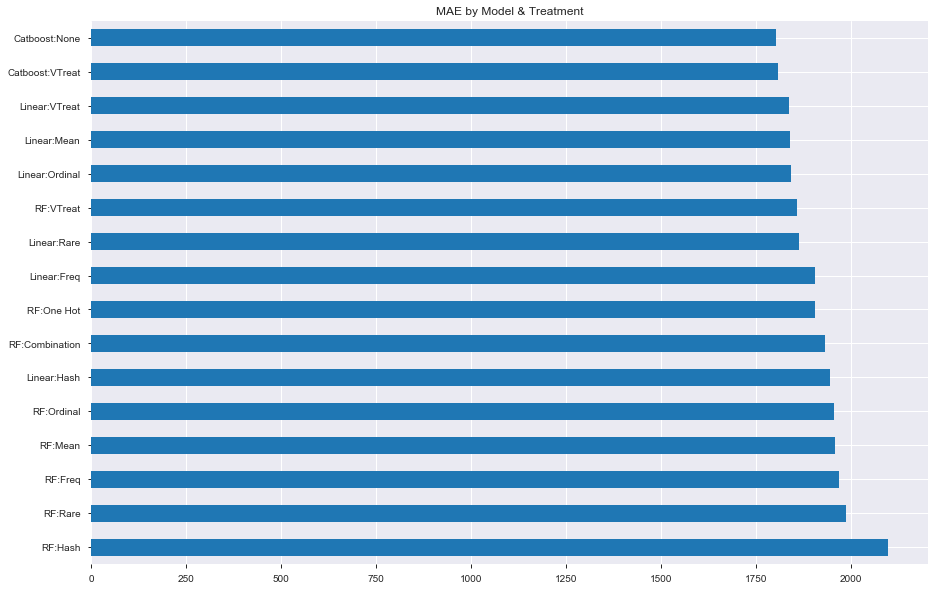

In [48]:
plt.figure(figsize=(15,10))
resultsDF['MAE'].sort_values(ascending=False).plot.barh(color='#1f77b4')
plt.title('MAE by Model & Treatment')

## Best RMSE

In [49]:
resultsDF.sort_values('RMSE')

Estimator Encoding          MAE           MSE  \
Catboost:VTreat       CatBoost   VTreat  1809.292343  7.169504e+06   
Catboost:None         CatBoost     None  1802.712855  7.194605e+06   
Linear:VTreat           Linear   VTreat  1836.856413  7.230088e+06   
Linear:Ordinal          Linear  Ordinal  1842.528797  7.233940e+06   
Linear:Mean             Linear     Mean  1839.768860  7.363863e+06   
Linear:Rare             Linear     Rare  1863.902639  7.364246e+06   
RF:VTreat        Random Forest   VTreat  1858.831908  7.505598e+06   
Linear:Freq             Linear     Freq  1904.550644  7.557520e+06   
Linear:Hash             Linear     Hash  1944.281958  7.785372e+06   
RF:Combination   Random Forest    Combo  1930.739087  8.129618e+06   
RF:One Hot       Random Forest  One Hot  1904.597014  8.131723e+06   
RF:Ordinal       Random Forest  Ordinal  1955.213077  8.201696e+06   
RF:Mean          Random Forest     Mean  1957.358213  8.219005e+06   
RF:Freq          Random Forest     Freq  1968.259393  8.307929e+06   
RF:Rare          Random Forest     Rare  1987.709370  8.556163e+06   
RF:Hash                     RF     Hash  2097.773166  9.322263e+06   

                        RMSE  
Catboost:VTreat  2677.592901  
Catboost:None    2682.276163  
Linear:VTreat    2688.882385  
Linear:Ordinal   2689.598435  
Linear:Mean      2713.643843  
Linear:Rare      2713.714480  
RF:VTreat        2739.634673  
Linear:Freq      2749.094374  
Linear:Hash      2790.228017  
RF:Combination   2851.248433  
RF:One Hot       2851.617562  
RF:Ordinal       2863.860252  
RF:Mean          2866.880748  
RF:Freq          2882.347884  
RF:Rare          2925.091972  
RF:Hash          3053.238069

Text(0.5, 1.0, 'RMSE by Model & Treatment')

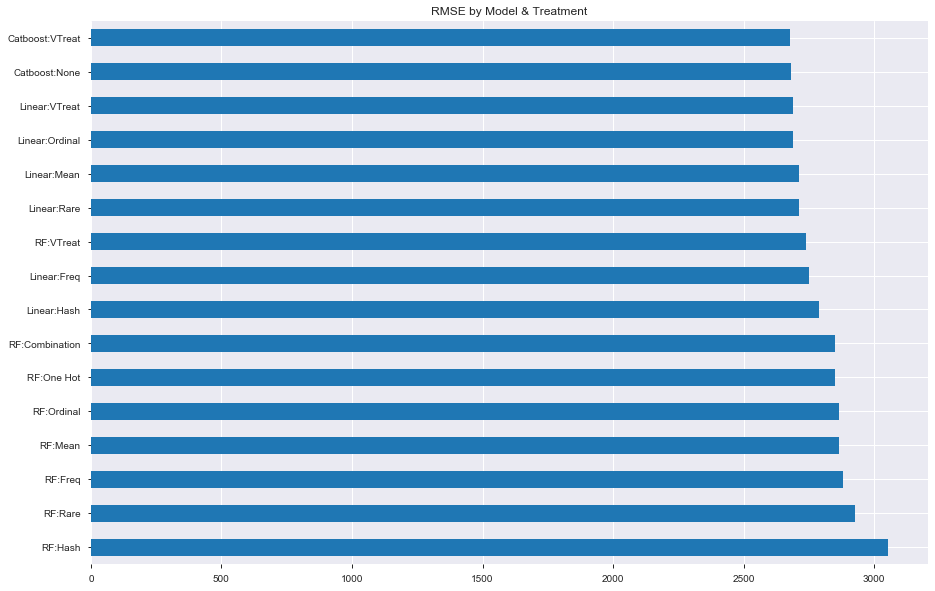

In [50]:
plt.figure(figsize=(15,10))
resultsDF['RMSE'].sort_values(ascending=False).plot.barh(color='#1f77b4')
plt.title('RMSE by Model & Treatment')

## Improvement
* Typical workflow uses One Hot Encoding for categorical features
* Applying OHE over all levels of the categorical variables is the baseline for improvement
* Although Linear models generally outperformed Random Forest they were unstable for plain OHE

### VTreat

In [51]:
mae_rf  = resultsDF.loc['RF:One Hot', 'MAE']
mae_vt = resultsDF.loc['RF:VTreat', 'MAE']
improvement = (mae_rf - mae_vt) * 100.0 / mae_rf
print('VTreat Improvement over Random Forest with OneHot treatement : {:.2f}%'.format(improvement))

VTreat Improvement over Random Forest with OneHot treatement : 2.40%


### CatBoost + VTreat

In [52]:
mae_rf  = resultsDF.loc['RF:One Hot', 'MAE']
mae_cat = resultsDF.loc['Catboost:VTreat', 'MAE']
improvement = (mae_rf - mae_cat) * 100.0 / mae_cat
print('CatBoost + VTreat Improvement over Random Forest with OneHot treatement : {:.2f}%'.format(improvement))

CatBoost + VTreat Improvement over Random Forest with OneHot treatement : 5.27%


# Conclusions
* Explored four libraries
 * Feature_engine (DataFrame -> DataFrame) vs (DataFrame -> np.array)
 * Categorical_Encoders (DataFrame -> DataFrame) Numerous encoding algorithms
 * VTreat - automated feature transformation & generation
 * CatBoost from Yandex - Strong support for categorical variables
* On this dataset:
 * CatBoost with no treatment beat Vtreat and our best efforts with feature encoding
 * VTreat finished in a close second
 * One Hot worked well on Random Forest, but led to instability in Linear Regression
 * Hashing didn't perform well, but allows control over the "space" while combining all categoricals
* VTreat has nice potential to handle the features part of your default flow 
 * EDA : Pandas Profiling
 * Features (Missing, Categorical, Scaling etc) : VTreat
 * Modeling : Pipeline 
 * Tuning / Selection : Hyperopt
 * Baseline Comparison : DummyEstimator
 * Explanations : Model Agnostic (Lime / Shap)
* CatBoost should be in your boosting techniques
 * Trains quickly
 * Handles categorical / object columns intrinsically
* Other Numerical Encodings
 * Consider Leave one out (LOO - Has been getting some run on Kaggle)
 * For binary classification include Weight of Evidence Encoding